Stochastic Modelling and Simulation project:
Multi-Robot Target Search using Probabilistic Consensus on Discrete Markov Chains.

In [1]:
import numpy as np
from Utils.Agent import Agent
from Utils.GridGraph import GridGraph
from MultiRobotTargetSearch import MultiRobotTargetSearch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
# np.random.seed(12345)


Experimental parameter:

In [3]:
N = 5 # number of agents

alpha = 0.2 # to be chosen in (0, 1/d_max) <- d_max = N-1

map_width = 10 # (meters)
map_height = 10

S = map_width * map_height # number of nodes (locations)


Graph initialization:

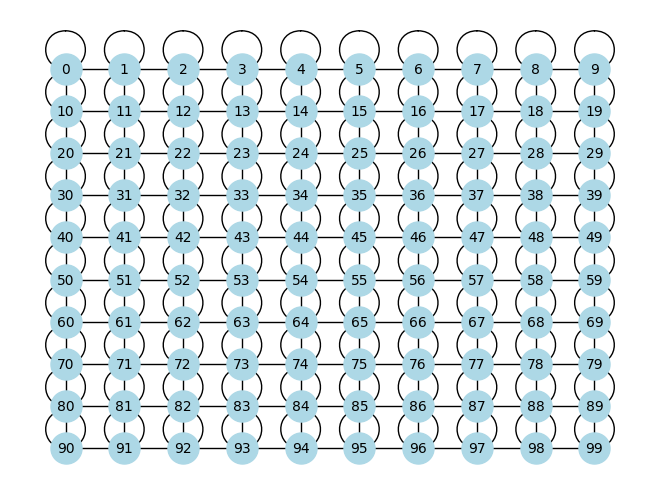

In [4]:
grid_graph = GridGraph(map_width, map_height)
grid_graph.plot_graph() 

Target init:

In [5]:
reference_information_state = 1
Z_r = [4, 5, 6] 
print("The reference information state is: " + str(reference_information_state))
print("Target is observable from nodes: " + str(Z_r))

The reference information state is: 1
Target is observable from nodes: [4, 5, 6]


Agents init:

In [6]:
def initAgents(number_of_agents, number_of_nodes):
    agent_list = []
    for i in range(number_of_agents):
        initial_node = np.random.randint(0, number_of_nodes)
        agent = Agent(i+1, initial_node)
        agent_list.append(agent)
    return agent_list    

agents = initAgents(N,S)
for ag in agents:
    print(ag)

Agent ID: 1, 
Position: 64 
Information state: 0.9107427143096251

Agent ID: 2, 
Position: 41 
Information state: 0.22701753091491506

Agent ID: 3, 
Position: 56 
Information state: 0.5720653403578543

Agent ID: 4, 
Position: 21 
Information state: 0.5162970588282398

Agent ID: 5, 
Position: 81 
Information state: 0.5905694698255234


Graph class representing agent's environment

Finished. Information State Vector: [[0.99074101]
 [1.        ]
 [0.99036338]
 [0.99013487]
 [0.99592808]
 [1.        ]]


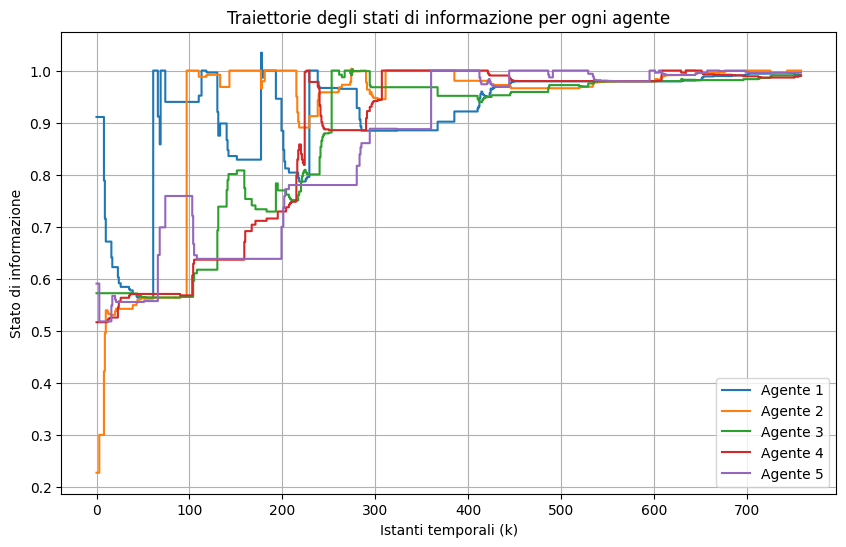

In [7]:
experiment = MultiRobotTargetSearch(agents, grid_graph, reference_information_state, Z_r, alpha)
experiment.run()
print(f"Finished. Information State Vector: {experiment.getInformationStateVector()}")        
experiment.plot_agents_information_state_trajectories()
#print(f"{experiment.getIterationNumber()} iterazioni in {experiment.getExecutionTime()} secondi")

In [8]:
# def plot_average_execution_time(agents_number_list, average_execution_time_list):
#     plt.figure(figsize=(8, 6))
#     plt.plot(agents_number_list, average_execution_time_list, marker='o', linestyle='-', color='b', label='Average Execution Time')
#     plt.xlabel("Number of Agents")
#     plt.ylabel("Average Execution Time (s)")
#     plt.title("Average Execution Time vs Number of Agents")
#     plt.legend()
#     plt.grid(True)
#     plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#     plt.show()

def plot_average_execution_time(agents_number_list, average_execution_time_list, std_deviation_list, x_label):
    plt.figure(figsize=(8, 6))
    
    plt.errorbar(
        agents_number_list, average_execution_time_list, yerr=std_deviation_list,
        fmt='o-', color='b', ecolor='gray', elinewidth=2, capsize=4, label='Average Execution Time'
    )
    
    plt.xlabel(x_label)
    plt.ylabel("Average Execution Time (iterations)")
    plt.title("Average Execution Time vs Number of Agents")
    plt.legend()
    plt.grid(True)
    
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.show()


Average time until consensus vs number of agents 

Experiment with 3 agents:
Iteration 0:
Iteration 1:
Iteration 2:
Iteration 3:
Iteration 4:
Iteration 5:
Iteration 6:
Iteration 7:
Iteration 8:
Iteration 9:
Iteration 10:
Iteration 11:
Iteration 12:
Iteration 13:
Iteration 14:
Iteration 15:
Iteration 16:
Iteration 17:
Iteration 18:
Iteration 19:
Iteration 20:
Iteration 21:
Iteration 22:
Iteration 23:
Iteration 24:
Iteration 25:
Iteration 26:
Iteration 27:
Iteration 28:
Iteration 29:
Iteration 30:
Iteration 31:
Iteration 32:
Iteration 33:
Iteration 34:
Iteration 35:
Iteration 36:
Iteration 37:
Iteration 38:
Iteration 39:
Iteration 40:
Iteration 41:
Iteration 42:
Iteration 43:
Iteration 44:
Iteration 45:
Iteration 46:
Iteration 47:
Iteration 48:
Iteration 49:
Iteration 50:
Iteration 51:
Iteration 52:
Iteration 53:
Iteration 54:
Iteration 55:
Iteration 56:
Iteration 57:
Iteration 58:
Iteration 59:
Iteration 60:
Iteration 61:
Iteration 62:
Iteration 63:
Iteration 64:
Iteration 65:
Iteration 66:
Iteration 67:
Iteration 68:
Iteration 69:
Iter

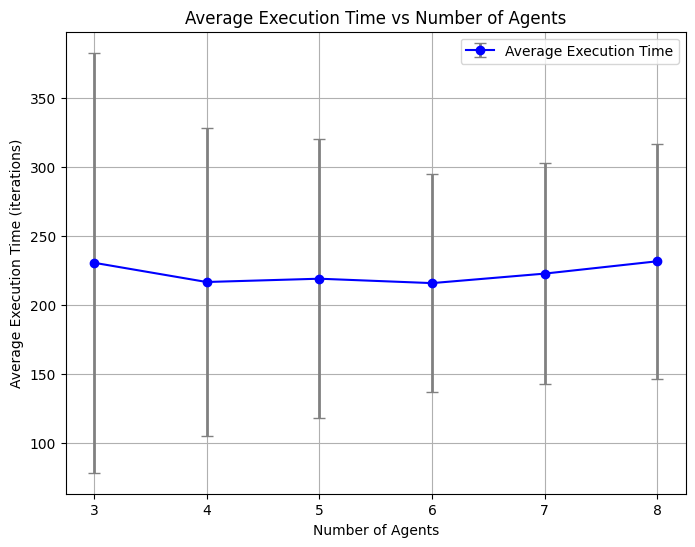

In [9]:
num_of_experiments = 100
N = [3,4,5,6,7,8]

average_consensus_time = []
average_standard_deviation = []

for agent_number in N:
    print(f"Experiment with {agent_number} agents:")
    nodesNumber = grid_graph.getNodesNumber()
    consensus_times = []
    alpha = 1 / (agent_number - 1)
    
    for j in range(num_of_experiments): 
        print(f"Iteration {j}:")
        agents = initAgents(agent_number, nodesNumber)
        experiment = MultiRobotTargetSearch(agents, grid_graph, reference_information_state, Z_r, alpha)
        experiment.run()
        consensus_times.append(experiment.getMeanConsensusTime())
    
    average_consensus_time.append(np.mean(consensus_times))
    average_standard_deviation.append(np.std(consensus_times))

plot_average_execution_time(N, average_consensus_time, average_standard_deviation, "Number of Agents")
# plot_average_execution_time(N, average_execution_time)
# plot_average_execution_time(N, average_iterations)


Average time until consensus vs grid_dimension

In [11]:
average_consensus_time = []
average_standard_deviation = []
grid_dimensions = [5,8,10,12,15,20]
N = 5
alpha = 1 / (N - 1)

for grid_dimension in grid_dimensions:
    nodesNumber = grid_dimension * grid_dimension
    consensus_times = []
    grid_graph = GridGraph(grid_dimension, grid_dimension)
    
    for j in range(num_of_experiments): 
        print(f"Iteration {j}:")
        agents = initAgents(N, nodesNumber)
        experiment = MultiRobotTargetSearch(agents, grid_graph, reference_information_state, Z_r, alpha)
        experiment.run()
        consensus_times.append(experiment.getMeanConsensusTime())
    
    average_consensus_time.append(np.mean(consensus_times))
    average_standard_deviation.append(np.std(consensus_times))

plot_average_execution_time(grid_dimensions, average_consensus_time, average_standard_deviation, "Grid dimension")

Iteration 0:
Iteration 1:
Iteration 2:
Iteration 3:
Iteration 4:
Iteration 5:
Iteration 6:
Iteration 7:
Iteration 8:
Iteration 9:
Iteration 10:
Iteration 11:
Iteration 12:
Iteration 13:
Iteration 14:
Iteration 15:
Iteration 16:
Iteration 17:
Iteration 18:
Iteration 19:
Iteration 20:
Iteration 21:
Iteration 22:
Iteration 23:
Iteration 24:
Iteration 25:
Iteration 26:
Iteration 27:
Iteration 28:
Iteration 29:
Iteration 30:
Iteration 31:
Iteration 32:
Iteration 33:
Iteration 34:
Iteration 35:
Iteration 36:
Iteration 37:
Iteration 38:
Iteration 39:
Iteration 40:
Iteration 41:
Iteration 42:
Iteration 43:
Iteration 44:
Iteration 45:
Iteration 46:
Iteration 47:
Iteration 48:
Iteration 49:
Iteration 50:
Iteration 51:
Iteration 52:
Iteration 53:
Iteration 54:
Iteration 55:
Iteration 56:
Iteration 57:
Iteration 58:
Iteration 59:
Iteration 60:
Iteration 61:
Iteration 62:
Iteration 63:
Iteration 64:
Iteration 65:
Iteration 66:
Iteration 67:
Iteration 68:
Iteration 69:
Iteration 70:
Iteration 71:
It

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

num_of_experiments = 100
agent_numbers = [3, 4, 5, 6, 7, 8]
grid_dimensions = [5, 8, 10, 12, 15, 20]

X_values = []  # Numero di agenti (asse X)
Y_values = []  # Tempo medio di consenso (asse Y)
Z_values = []  # Dimensione della griglia (asse Z)

# Calcolo del tempo di consenso per ogni combinazione di (agent_number, grid_dimension)
for agent_number in agent_numbers:
    for grid_dimension in grid_dimensions:
        nodesNumber = grid_dimension * grid_dimension
        grid_graph = GridGraph(grid_dimension, grid_dimension)
        consensus_times = []
        alpha = 1 / (agent_number - 1)
        
        for j in range(num_of_experiments): 
            agents = initAgents(agent_number, nodesNumber)
            experiment = MultiRobotTargetSearch(agents, grid_graph, reference_information_state, Z_r, alpha)
            experiment.run()
            consensus_times.append(experiment.getMeanConsensusTime())
        
        avg_time = np.mean(consensus_times)

        X_values.append(agent_number)
        Y_values.append(avg_time)
        Z_values.append(grid_dimension)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_values, Y_values, Z_values, c='b', marker='o')

ax.set_xlabel('Number of agents')
ax.set_ylabel('Mean average time until consensus (iterations)')
ax.set_zlabel('Grid dimension (m)')

plt.show()
